In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import cv2

In [7]:
# -----------------------------
# PARAMETERS
# -----------------------------
data_dir = "./dataset"   
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
TARGET_SIZE = 4000

In [8]:
# -----------------------------
# LOAD ALL FILES & LABELS
# -----------------------------
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c:i for i,c in enumerate(classes)}

all_image_paths = []
all_labels = []
for cls in classes:
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([class_to_index[cls]]*len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Classes:", classes)
print("Original dataset size:", len(all_image_paths))

Classes: ['normal', 'osteoporosis']
Original dataset size: 372


In [9]:
# -----------------------------
# NORMALIZATION FUNCTION
# -----------------------------
def normalization(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)       # grayscale
    img = tf.image.resize(img, IMG_SIZE)           # resize
    img = tf.image.grayscale_to_rgb(img)           # convert to RGB
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # normalize
    return img, label

# -----------------------------
# STRONG AUGMENTATION FUNCTION
# -----------------------------
def augment_image_strong(img, label, num_aug=10):
    datasets = []
    # original
    datasets.append(tf.data.Dataset.from_tensors((img, label)))
    # augmented copies
    for _ in range(num_aug-1):
        aug_img = tf.image.random_flip_left_right(img)
        aug_img = tf.image.random_flip_up_down(aug_img)
        aug_img = tf.image.random_brightness(aug_img, max_delta=0.2)
        aug_img = tf.image.random_contrast(aug_img, 0.8, 1.2)
        aug_img = tf.image.rot90(aug_img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        datasets.append(tf.data.Dataset.from_tensors((aug_img, label)))
    # merge
    ds = datasets[0]
    for extra in datasets[1:]:
        ds = ds.concatenate(extra)
    return ds


In [11]:
# -----------------------------
# BUILD FULL AUGMENTED DATASET
# -----------------------------
AUG_PER_IMAGE = TARGET_SIZE // len(all_image_paths)  # ≈ 10
print("Each image will be expanded into:", AUG_PER_IMAGE, "versions")

base_ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_labels))
base_ds = base_ds.map(normalization, num_parallel_calls=AUTOTUNE)
full_aug_ds = base_ds.flat_map(lambda x, y: augment_image_strong(x, y, AUG_PER_IMAGE))

# Count dataset size (streaming, no numpy)
aug_count = sum(1 for _ in full_aug_ds)
print("Augmented dataset size:", aug_count)

Each image will be expanded into: 10 versions
Augmented dataset size: 3720


In [12]:
# -----------------------------
# SPLIT TRAIN / VAL / TEST (70/15/15)
# -----------------------------
train_size = int(0.7 * aug_count)
val_size   = int(0.15 * aug_count)

full_aug_ds = full_aug_ds.shuffle(aug_count, reshuffle_each_iteration=False)

train_ds = full_aug_ds.take(train_size)
val_test_ds = full_aug_ds.skip(train_size)
val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

In [ ]:
print("Train batches:", train_ds.cardinality().numpy())
print("Val batches  :", val_ds.cardinality().numpy())
print("Test batches :", test_ds.cardinality().numpy())

train_count = sum(1 for _ in train_ds)
val_count   = sum(1 for _ in val_ds)
test_count  = sum(1 for _ in test_ds)

print("Train batches:", train_count)
print("Val batches  :", val_count)
print("Test batches :", test_count)


Train batches: -2
Val batches  : -2
Test batches : -2


In [ ]:
def make_dataset_7(paths, labels, num_aug=2):
    """Build dataset with Normalization + Dataset Expansion"""
    base_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    base_ds = base_ds.map(normalization, num_parallel_calls=AUTOTUNE)  

    # expand dataset: each image → original + num_aug augmentations
    base_ds = base_ds.flat_map(lambda x, y: augment_image(x, y, num_aug)) 

    return base_ds.shuffle(512).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds_7 = make_dataset_7(train_paths, train_labels, num_aug=2)  # expanded
val_ds_7   = make_dataset_7(val_paths, val_labels, num_aug=0)      # no augmentation
test_ds_7  = make_dataset_7(test_paths, test_labels, num_aug=0)    # no augmentation

# --- Check sizes ---
train_count_7 = sum(1 for _ in train_ds_7.unbatch())
val_count_7   = sum(1 for _ in val_ds_7.unbatch())
test_count_7  = sum(1 for _ in test_ds_7.unbatch())

print("\n=== Pipeline 7 Dataset Sizes (Normalization + Expansion) ===")
print(f"Train set size: {train_count_7}")   # should be ~3× train_paths
print(f"Val set size  : {val_count_7}")     # same as val_paths
print(f"Test set size : {test_count_7}")    # same as test_paths

Classes: ['normal', 'osteoporosis']
normal: 186 images
osteoporosis: 186 images
Train: 260 Val: 56 Test: 56
Train dist: {'normal': 130, 'osteoporosis': 130}
Val dist: {'normal': 28, 'osteoporosis': 28}
Test dist: {'normal': 28, 'osteoporosis': 28}


In [12]:
IMG_SIZE = (224,224)
BATCH_SIZE = 16

# def _load(path, label):
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=3)   # always RGB
#     image = tf.image.resize(image, IMG_SIZE)
#     image = preprocess_input(image)   # ✅ correct EfficientNet preprocessing
#     return image, tf.cast(label, tf.int32)

def _load(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)   # force grayscale ✅
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0        # normalize 0–1
    return image, tf.cast(label, tf.int32)


def paths_to_dataset(paths, labels, batch_size=BATCH_SIZE, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)

    def _process(path, label):
        img, label = _load(path, label)
        if augment:
            aug = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.05),
                tf.keras.layers.RandomZoom(0.05),
            ])
            img = aug(img, training=True)
        return img, label

    ds = ds.map(_process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = paths_to_dataset(train_paths.tolist(), train_labels.tolist(), shuffle=True, augment=False)
val_ds   = paths_to_dataset(val_paths.tolist(), val_labels.tolist())
test_ds  = paths_to_dataset(test_paths.tolist(), test_labels.tolist())

In [13]:
# Check a sample image shape from the tf.data pipeline
for imgs, lbls in train_ds.take(1):
    print("batch img shape:", imgs.shape)      # expect (batch,224,224,3)
    print("min/max:", tf.reduce_min(imgs).numpy(), tf.reduce_max(imgs).numpy())
    break

# Or check a raw file:
import tensorflow as tf
p = train_paths[0]
img_raw = tf.io.decode_jpeg(tf.io.read_file(p), channels=0)  # channels=0 -> original channels
print("raw channels:", img_raw.shape)


batch img shape: (16, 224, 224, 1)
min/max: 0.0 1.0
raw channels: (1024, 510, 3)


In [14]:
# Cell 4: Model (Pipeline 2, corrected)
num_classes = len(classes)

base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224,224,1))

base_model.trainable = False   # freeze base model

inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,048,991 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,217 (16.07 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,048,991 (15.45 MB)

In [15]:
EPOCHS = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


Epoch 1/10


17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 919ms/step - accuracy: 0.4654 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 634ms/step - accuracy: 0.4692 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 695ms/step - accuracy: 0.4769 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 777ms/step - accuracy: 0.4808 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 700ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 811ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 927ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 -

In [16]:
for x, y in val_ds.take(1):
    print(x.shape, y.numpy())


(16, 224, 224, 1) [1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1]


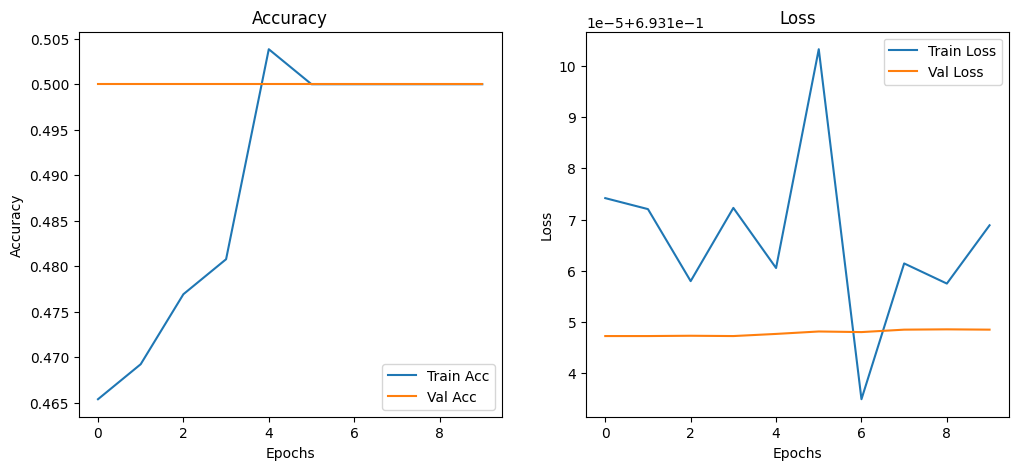

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend(); plt.title("Loss")

plt.show()


In [19]:
def evaluate_and_report(model, dataset, split_name="Test"):
    preds = model.predict(dataset)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.array([int(y.numpy()) for x,y in dataset.unbatch()])

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n{split_name} -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()

    print("Predictions distribution:", np.bincount(y_pred))
    print("True distribution:", np.bincount(y_true))

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  

Validation -> Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1: 0.3333
              precision    recall  f1-score   support

      normal       0.50      1.00      0.67        28
osteoporosis       0.00      0.00      0.00        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

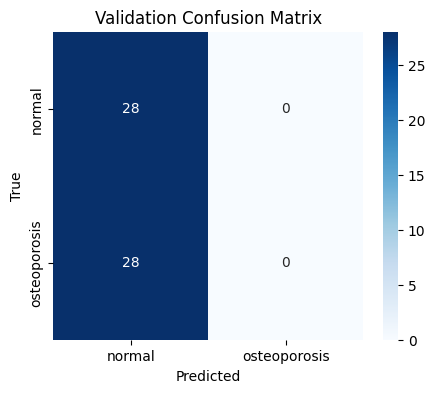

Predictions distribution: [56]
True distribution: [28 28]
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step

Test -> Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1: 0.3333
              precision    recall  f1-score   support

      normal       0.50      1.00      0.67        28
osteoporosis       0.00      0.00      0.00        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

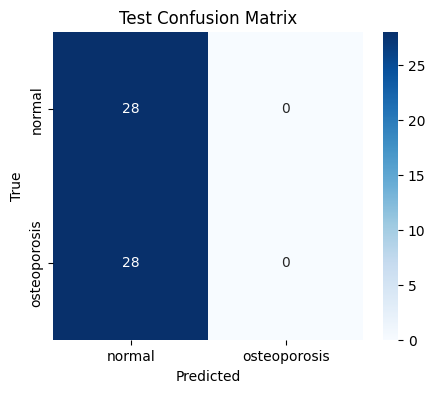

Predictions distribution: [56]
True distribution: [28 28]


In [20]:
evaluate_and_report(model, val_ds, split_name="Validation")
evaluate_and_report(model, test_ds, split_name="Test")

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


In [ ]:
def _load_norm(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    
    # Scale [0,255] -> [0,1]
    image = tf.cast(image, tf.float32) / 255.0  

    # Normalize per image: (x - mean) / std
    mean, var = tf.nn.moments(image, axes=[0,1], keepdims=False)
    std = tf.sqrt(var)
    image = (image - mean) / (std + 1e-6)
    
    return image, label

def paths_to_dataset_norm(paths, labels, batch_size=16, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)

    ds = ds.map(_load_norm, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Build datasets
train_ds2 = paths_to_dataset_norm(train_paths.tolist(), train_labels.tolist(), shuffle=True)
val_ds2   = paths_to_dataset_norm(val_paths.tolist(), val_labels.tolist())
test_ds2  = paths_to_dataset_norm(test_paths.tolist(), test_labels.tolist())


In [ ]:
num_classes = len(classes)
base_model2 = tf.keras.applications.EfficientNetB0(
    weights=None, include_top=False, input_shape=(224, 224, 3)
)
base_model2.trainable = True

inputs2 = tf.keras.Input(shape=(224, 224, 3))
x2 = base_model2(inputs2, training=True)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
x2 = tf.keras.layers.Dense(128, activation="relu")(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
outputs2 = tf.keras.layers.Dense(num_classes, activation="softmax")(x2)
model2 = tf.keras.Model(inputs2, outputs2)

model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

model2.summary()

In [ ]:
EPOCHS = 10
history2 = model2.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=EPOCHS
)


In [ ]:
preds2 = model2.predict(test_ds2)
y_pred2 = np.argmax(preds2, axis=1)
y_true2 = np.concatenate([y.numpy() for x,y in test_ds2], axis=0)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc2 = accuracy_score(y_true2, y_pred2)
prec2 = precision_score(y_true2, y_pred2, average="macro", zero_division=0)
rec2 = recall_score(y_true2, y_pred2, average="macro", zero_division=0)
f12 = f1_score(y_true2, y_pred2, average="macro", zero_division=0)

print(f"Pipeline 2 -> Accuracy: {acc2:.4f}, Precision: {prec2:.4f}, Recall: {rec2:.4f}, F1: {f12:.4f}")